In [1]:
# Import required libraries
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import pickle
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Define the 10 ImageNet images URLs and their details
#List containing names of the images to create the dictionary
key_names = ['West_Highland_white_terrier', 'American_coot', 'racer', 'flamingo', 'kite', 'goldfish', 'tiger_shark', 'vulture', 'common_iguana', 'orange']

### TOKEN  ###
TOKEN = "REDACTED" # to be changed according to your token (given to you for the assignments via email)


IMAGENET_URLS = [
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02098286_West_Highland_white_terrier.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02018207_American_coot.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n04037443_racer.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02007558_flamingo.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01608432_kite.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01443537_goldfish.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01491361_tiger_shark.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01616318_vulture.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01677366_common_iguana.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n07747607_orange.JPEG'
]

In [3]:
# Load and setup ResNet50 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [4]:
# Image Loading Functions

def load_image_from_url(url):
    """Load image from URL"""
    try:
        response = requests.get(url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert('RGB')
        return image
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        # Return a dummy image if URL fails
        return Image.new('RGB', (224, 224), color='gray')

def load_image_metadata():
        """Load ImageNet Image, Image URLS, Class Labels and Indexes"""
        key_labels = [label.replace('_', ' ') for label in key_names]
        image_metadata = {}
            
        try:
            url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
            response = requests.get(url)
            
            # Get Image Label and Index
            labels = response.text.strip().split('\n')
            indexes = [labels.index(label) for label in key_labels]

            for i in range(len(key_names)):
                image_metadata[key_names[i]] = {
                    "idx" : indexes[i],
                    "url" : IMAGENET_URLS[i],
                    "image" : load_image_from_url(IMAGENET_URLS[i])
                }
            return image_metadata
        except:
            for i in range(len(key_names)):
                image_metadata[key_names[i]] = {
                    "url" : IMAGENET_URLS[i],
                    "idx" : i,
                    "image" : load_image_from_url(IMAGENET_URLS[i])
                }
            
            return image_metadata

In [94]:
# PARAMETER OPTIMIZATION FUNCTIONS

def compute_images_statistics(images_metadata):
    edge_densities = []
    color_variance = []
    for name, metadata in images_metadata.items():
        image = metadata["image"]
        # Convert to grayscale for analysis
        gray = np.mean(image, axis=2)
    
        # Calculate complexity metrics
        edge_densities.append(np.std(gray))  # Higher std indicates more edges
        color_variance.append(np.var(image))
        
    # Compute percentile thresholds from all images       
    ed_p50, ed_p75 = np.percentile(edge_densities, 50), np.percentile(edge_densities, 75)
    cv_p50, cv_p75 = np.percentile(color_variance, 50), np.percentile(color_variance, 75)
    return ed_p50, ed_p75, cv_p50, cv_p75 

def analyze_image_complexity(image_array, ed_p50, ed_p75, cv_p50, cv_p75):
    """Analyze image complexity to determine optimal LIME parameters"""
    # Convert to grayscale for analysis
    gray = np.mean(image_array, axis=2)
    
    # Calculate complexity metrics
    edge_density = np.std(gray)  # Higher std indicates more edges
    color_variance = np.var(image_array)
    
    # Determine complexity level
    if edge_density > ed_p75 and color_variance > cv_p75:
        complexity = "high"
    elif edge_density > ed_p50 or color_variance > cv_p50:
        complexity = "medium"
    else:
        complexity = "low"
    
    return complexity, edge_density, color_variance

def get_optimal_params(complexity):
    """Get optimal LIME parameters based on image complexity"""
    params = {
            "labels": (1,),
            "hide_color": 0,
            "top_labels": 5,
            "num_features": 10,      
            "num_samples": 300,      
            "batch_size": 32,
            "segmentation_fn": None, 
            "distance_metric": "cosine",
            "model_regressor": None,
            "random_seed": 42,
            'num_superpixels': 60,
            'compactness': 20
    }
    if complexity == "high":
        params.update({
            'num_superpixels': 60,
            'num_samples': 300,
            'num_features': 15,
            'compactness': 20
        })
    elif complexity == "medium":
        params.update({
            'num_superpixels': 40,
            'num_samples': 200,
            'num_features': 10,
            'compactness': 15
        })
    else:  # low complexity
        params.update({
            'num_superpixels': 30,
            'num_samples': 150,
            'num_features': 8,
            'compactness': 10
        })
    return params


In [95]:
# LIME Analysis with Parameter Optimization
class LIMEAnalyzer:
    def __init__(self):
        self.explainer = lime_image.LimeImageExplainer()
        self.optimized_params = {}
        # Use provided model or default to ResNet50
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.model.eval()

        # Image preprocessing and prediction function for LIME
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])

    def classifier_fn(self, images):
        """Prediction function for LIME"""
        predictions = []
        
        # Process images in batches
        batch_size = 32
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            
            # Convert to tensors and preprocess
            image_tensors = []
            for img in batch:
                # Convert numpy array to PIL Image
                img_pil = Image.fromarray(img.astype('uint8')).convert('RGB')
                # Convert to Tensor and Apply transformations
                tensor_img = self.transform(img_pil).unsqueeze(0)
                image_tensors.append(tensor_img)

            # Stack the Batch tensors
            batch_tensors = torch.cat(image_tensors, dim=0).to(device)
            
            # Make predictions
            with torch.no_grad():
                outputs = self.model(batch_tensors)
                probs = F.softmax(outputs, dim=1)
                predictions.extend(probs.cpu().numpy())
    
        return np.vstack(predictions)
            
    def get_prediction(self, image):
        """Get top predicted class index and confidence"""
        input_tensor = self.transform(image).unsqueeze(0)  # Shape: [1, 3, 224, 224]

        with torch.no_grad():
            outputs = self.model(input_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            confidence = probs[0][pred_class].item()

        return pred_class, confidence
    
    def generate_explanation(self, image, target_class, image_name):
        """Generate LIME explanation with optimized parameters"""
        # Convert PIL to numpy array
        image_array = np.array(image.resize((224, 224)))
        
        # Analyze complexity
        complexity, edge_density, color_variance = analyze_image_complexity(image_array, ed_p50, ed_p75, cv_p50, cv_p75)
        
        # Get optimal parameters
        params = get_optimal_params(complexity)
        self.optimized_params[image_name] = {
            'complexity': complexity,
            'edge_density': edge_density,
            'color_variance': color_variance,
            'parameters': params
        }
        
        print(f"[Complexity Analysis]: Complexity={complexity}, Superpixels={params['num_superpixels']}, Samples={params['num_samples']}")

        # Get top predicted class from model
        pred_class, confidence = self.get_prediction(image)
        print(f"[Class Prediction]: True Class = {target_class}, Predicted Class = {pred_class}, Confidence = {confidence:.3f}")
        
        # Generate superpixels and segmentation
        segments = slic(image_array, 
                       n_segments=params['num_superpixels'], 
                       compactness=params['compactness'], 
                       sigma=1)
        
        # Generate LIME explanation
        explanation = self.explainer.explain_instance(
            image_array,
            self.classifier_fn,
            top_labels=params["top_labels"],
            hide_color=params["hide_color"],
            num_samples=params['num_samples'],
            segmentation_fn=lambda x: segments
        )
        
        # Get explanation for target class
        temp, mask = explanation.get_image_and_mask(
            pred_class,
            positive_only=True,
            num_features=params['num_features'],
            hide_rest=False
        )
        
        return {
            'explanation': explanation,
            'mask': mask,
            'segments': segments,
            'highlighted_image': temp,
            'complexity': complexity,
            'confidence': confidence,
            'predicted_class': pred_class,
            'parameters': params
        }

# Initialize LIME analyzer
lime_analyzer = LIMEAnalyzer()

Computing Complexity Statistics

(0) [West_Highland_white_terrier] LIME Processing
[Complexity Analysis]: Complexity=high, Superpixels=60, Samples=300
[Class Prediction]: True Class = 203, Predicted Class = 203, Confidence = 0.582


  0%|          | 0/300 [00:00<?, ?it/s]


(1) [American_coot] LIME Processing
[Complexity Analysis]: Complexity=low, Superpixels=30, Samples=150
[Class Prediction]: True Class = 137, Predicted Class = 137, Confidence = 0.646


  0%|          | 0/150 [00:00<?, ?it/s]


(2) [racer] LIME Processing
[Complexity Analysis]: Complexity=medium, Superpixels=40, Samples=200
[Class Prediction]: True Class = 751, Predicted Class = 817, Confidence = 0.135


  0%|          | 0/200 [00:00<?, ?it/s]


(3) [flamingo] LIME Processing
[Complexity Analysis]: Complexity=low, Superpixels=30, Samples=150
[Class Prediction]: True Class = 130, Predicted Class = 130, Confidence = 0.569


  0%|          | 0/150 [00:00<?, ?it/s]


(4) [kite] LIME Processing
[Complexity Analysis]: Complexity=medium, Superpixels=40, Samples=200
[Class Prediction]: True Class = 21, Predicted Class = 94, Confidence = 0.078


  0%|          | 0/200 [00:00<?, ?it/s]


(5) [goldfish] LIME Processing
[Complexity Analysis]: Complexity=low, Superpixels=30, Samples=150
[Class Prediction]: True Class = 1, Predicted Class = 1, Confidence = 0.493


  0%|          | 0/150 [00:00<?, ?it/s]


(6) [tiger_shark] LIME Processing
[Complexity Analysis]: Complexity=low, Superpixels=30, Samples=150
[Class Prediction]: True Class = 3, Predicted Class = 3, Confidence = 0.675


  0%|          | 0/150 [00:00<?, ?it/s]


(7) [vulture] LIME Processing
[Complexity Analysis]: Complexity=low, Superpixels=30, Samples=150
[Class Prediction]: True Class = 23, Predicted Class = 23, Confidence = 0.427


  0%|          | 0/150 [00:00<?, ?it/s]


(8) [common_iguana] LIME Processing
[Complexity Analysis]: Complexity=low, Superpixels=30, Samples=150
[Class Prediction]: True Class = 39, Predicted Class = 39, Confidence = 0.314


  0%|          | 0/150 [00:00<?, ?it/s]


(9) [orange] LIME Processing
[Complexity Analysis]: Complexity=medium, Superpixels=40, Samples=200
[Class Prediction]: True Class = 950, Predicted Class = 950, Confidence = 0.394


  0%|          | 0/200 [00:00<?, ?it/s]

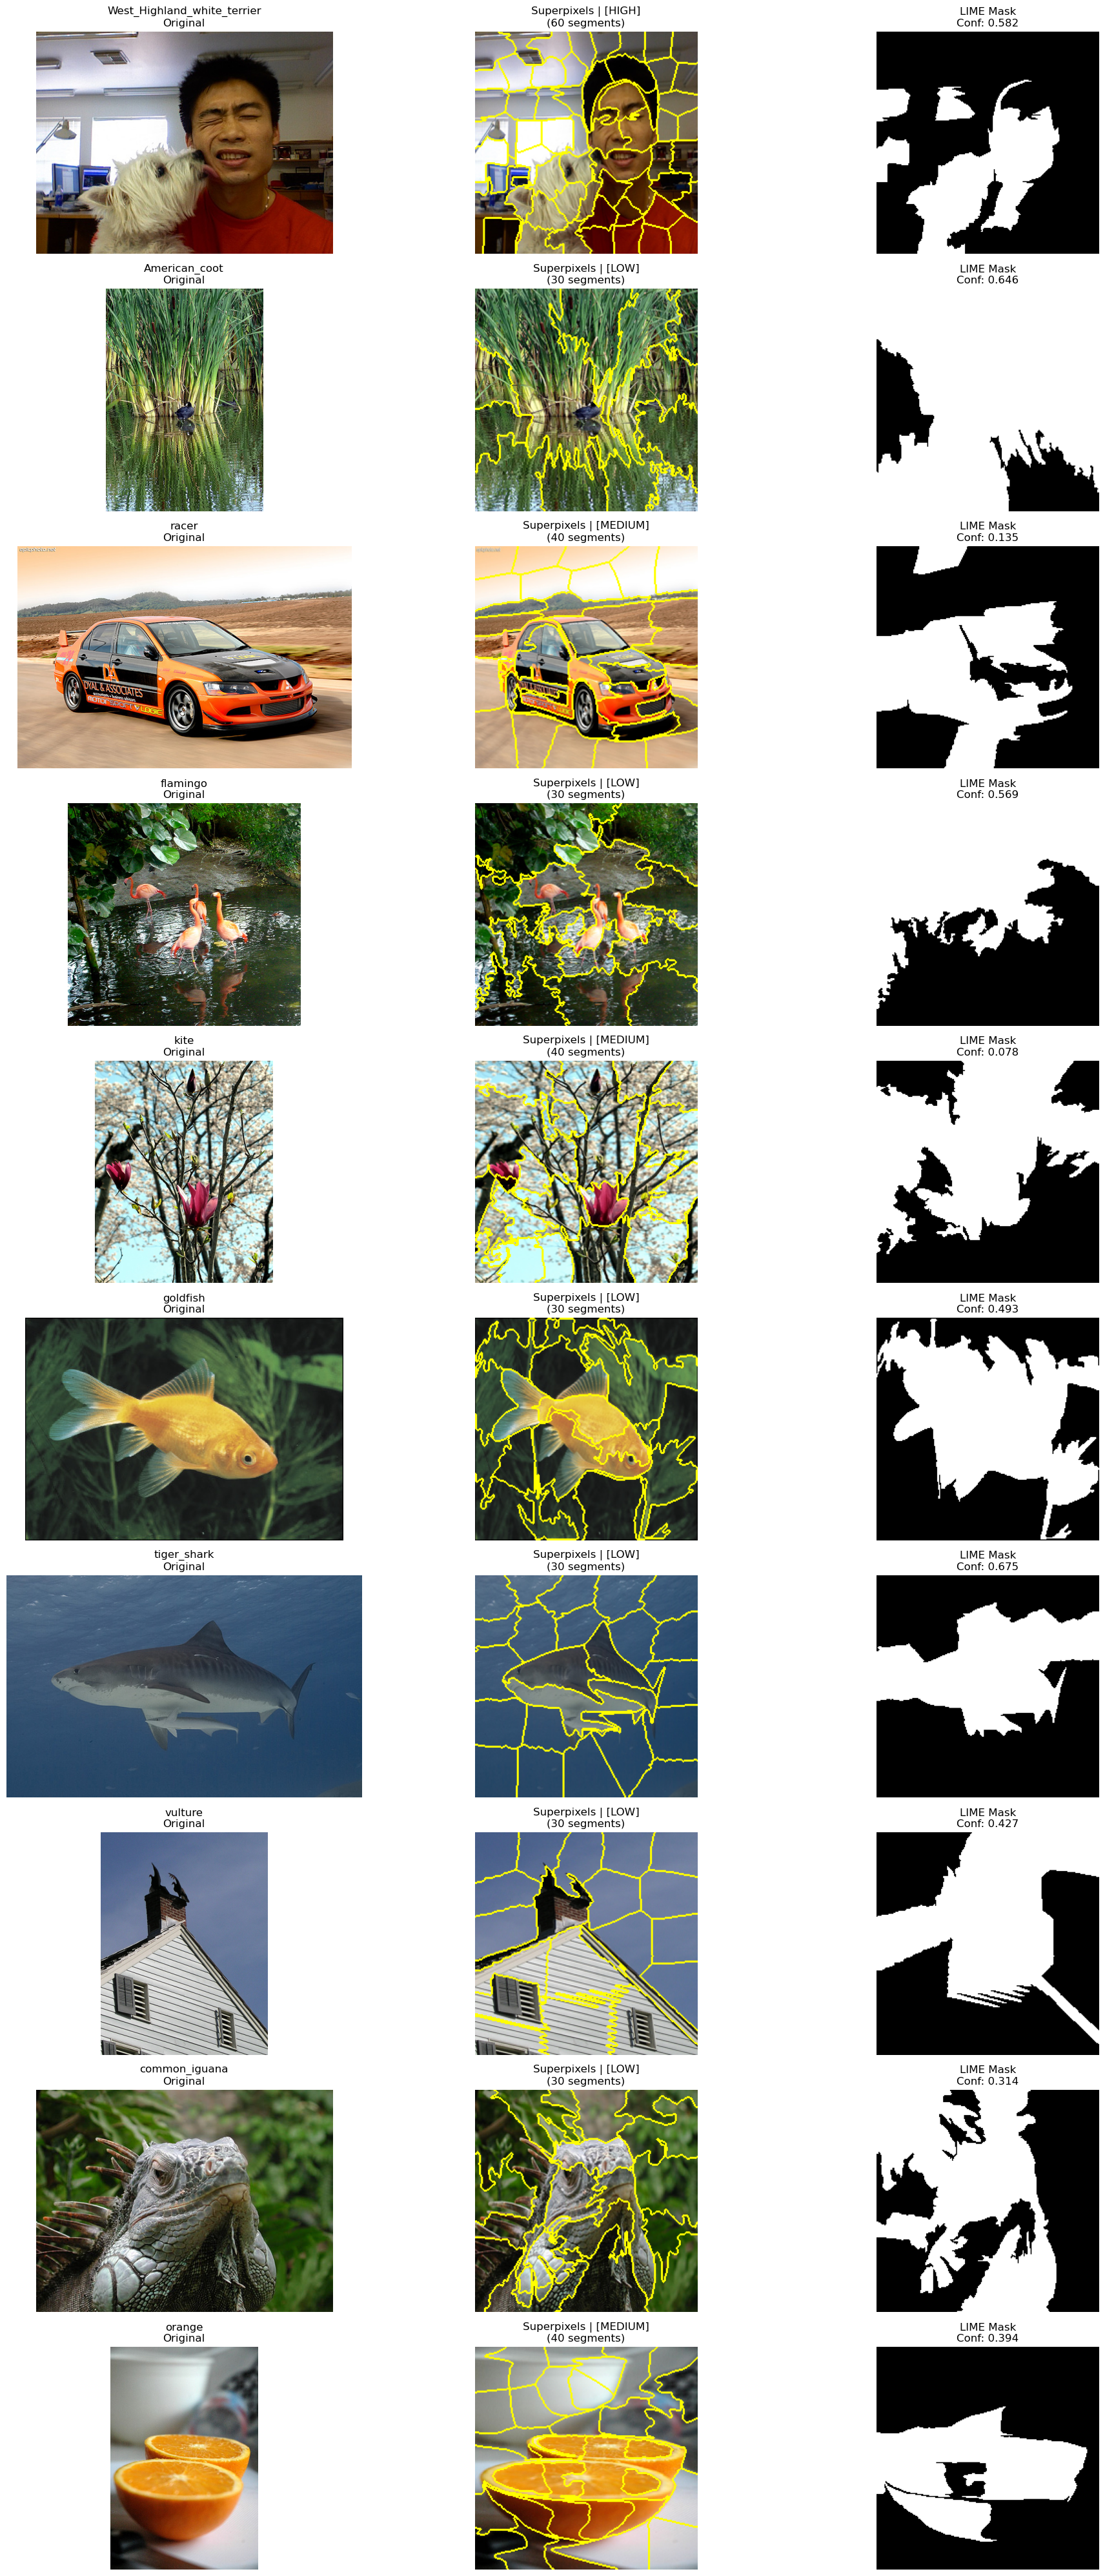


LIME analysis completed!


In [111]:
# Generate LIME explanations for all images
lime_results = {}

plt.figure(figsize=(20, 40))

# Generate image Metadata
image_metadata = load_image_metadata()

# Generate Complexity Statistics
print("Computing Complexity Statistics")
ed_p50, ed_p75, cv_p50, cv_p75 = compute_images_statistics(image_metadata)

for idx, (image_name, metadata) in enumerate(image_metadata.items()):
    print(f"\n({idx}) [{image_name}] LIME Processing")
    image = metadata["image"]
    true_idx = metadata["idx"]
    
    # Generate LIME explanation
    result = lime_analyzer.generate_explanation(image, true_idx, image_name)
    lime_results[image_name] = result
    
    plt.subplot(10, 3, idx * 3 + 1)
    plt.imshow(image)
    plt.title(f'{image_name}\nOriginal')
    plt.axis('off')

    # Superpixels
    plt.subplot(10, 3, idx * 3 + 2)
    plt.imshow(mark_boundaries(result['highlighted_image'] / 255.0, result['segments']))
    plt.title(f'Superpixels | [{result["complexity"].upper()}]\n({result["parameters"]["num_superpixels"]} segments)')
    plt.axis('off')

    # Mask and Confidence
    plt.subplot(10, 3, idx * 3 + 3)
    plt.imshow(result['mask'], cmap='gray')
    plt.title(f'LIME Mask\nConf: {result["confidence"]:.3f}')
    plt.axis('off')
    

plt.tight_layout()
plt.savefig('lime_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nLIME analysis completed!")

In [97]:
# Save optimized parameters for submission
params = {}

for image_name, params_info in lime_analyzer.optimized_params.items():
    params[image_name] = {
        "labels": (1, ),
        "hide_color": 0,
        "top_labels": 5,
        "num_features": params_info['parameters']['num_features'],
        "num_samples": params_info['parameters']['num_samples'],
        "batch_size" : 32,
        "segmentation_fn": None,
        "distance_metric": "cosine",
        "model_regressor": None,
        "random_seed": 42
    }

# Save as pickle file for submission
with open('explain_params.pkl', 'wb') as f:
    pickle.dump(params, f)

print("Optimized parameters saved to 'explain_params.pkl'")

Optimized parameters saved to 'explain_params.pkl'


In [108]:
# Submit pickle file to server
try:
    url = "http://34.122.51.94:9091/lime"    
    with open('explain_params.pkl', "rb") as f:
        response = requests.post(
            url,
            files={"file": f},
            headers={"token": TOKEN}
        )   
    print(f"Submission response status: {response.status_code}")    
    response_json = response.json()
    print(f"Response JSON: {response_json}")
    
except Exception as e:
    print(f"Error during submission: {e}")
    

Submission response status: 200
Response JSON: {'avg_iou': 0.34343485227512593, 'avg_time': 1.3282623767852784}
